# Cohort Project Week 4: Solutions of the Quantum Natural Language Processing Tutorial (Team 8)

In this notebook, we present the solutions to the exercises specified in the notebook qnlp_tutorial.ipynb

![title](images/logo.png)

### Installation procedure

In [1]:
# conda create -n discopy
# conda activate discopy
# conda install python
# pip install discopy
# pip install pytket
# pip install pytket-qiskit
# pip install tensornetwork

### Import essential packages

In [1]:
from discopy import * #Ob, Ty, Box, drawing, Id, Swap, Diagram, Functor, Dim, Tensor, Cup, Cap, tensor, Word, pregroup
import pytket as tk
import tensornetwork as tn
import numpy as np
import matplotlib.pyplot as plt

![exercise1](images/exercise1.png)

### 1. **Exercise:** Draw your favorite cooking recipe as a diagram. You'll want to keep your ingredients in order if you want to avoid swapping them too much.

### Four Eggs Omelette (Vegetables/Bacon & Cheese Edition)

In [13]:
# Egg states and butter
egg, white, yolk = Ty('egg'), Ty('white'), Ty('yolk')
butter, melted_butter = Ty('butter'), Ty('melted butter')
yolk_in_butter = Ty('yolk in butter')
white_filling = Ty('filling with egg white')
unfilled_omelette = Ty('unfilled omelette')
# Fillings for the omelette
non_veg_ingredients = Ty('bacon', 'cheese')
veg_ingredients = Ty('tomato', 'garlic')
cut_ingredients = Ty('cut ingredients')
# result
completed_omelette = Ty('completed omelette')

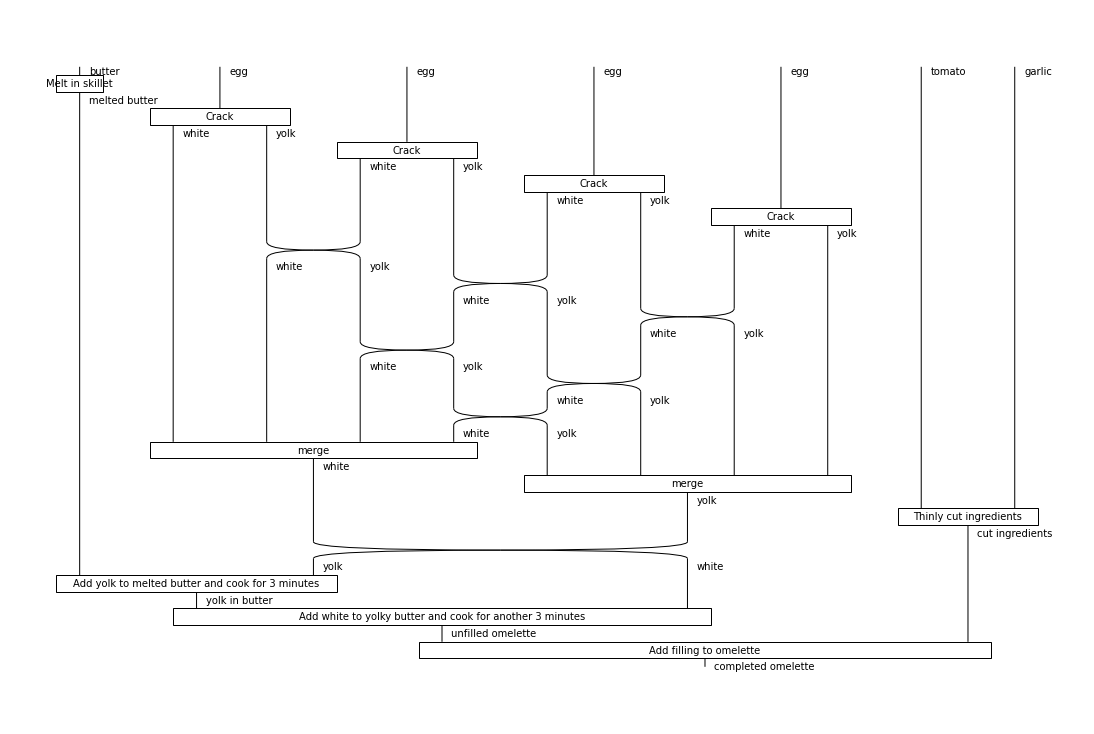

In [15]:
recipes = ['vegetable', 'non-vegetable']
recipe  = recipes[0]

merge = lambda x: Box('merge', x @ x @ x @ x, x)

melt_butter = Box('Melt in skillet', dom=butter, cod=melted_butter) 
thin_cut = Box('Thinly cut ingredients', dom=non_veg_ingredients if recipe != 'vegetable' else veg_ingredients, cod=cut_ingredients)
add_yolk = Box('Add yolk to melted butter and cook for 3 minutes', dom=melted_butter @ yolk, cod=yolk_in_butter)
add_white = Box('Add white to yolky butter and cook for another 3 minutes', dom=yolk_in_butter @ white, cod=unfilled_omelette)
prepare_filling = Box('Add egg white to the filling', dom=white @ cut_ingredients, cod=white_filling)

fill_omelette   = Box('Add filling to omelette', dom=unfilled_omelette @ cut_ingredients, cod=completed_omelette)
complete_recipe = Box('Add filling to yolk and cook for 3 minues', dom=yolk_in_butter @ white_filling, cod=completed_omelette)

crack = Box('Crack', dom = egg, cod = white @ yolk)
crack_four_eggs =  crack @ crack @ crack @ crack \
    >> Id(white) @ Swap(yolk, white) @ Swap(yolk, white) @ Swap(yolk, white) @ Id(yolk)\
    >> Id(white) @ Id(white) @ Swap(yolk, white) @ Swap(yolk, white) @ Id(yolk) @ Id(yolk)\
    >> Id(white) @ Id(white) @ Id(white) @ Swap(yolk, white) @ Id(yolk) @ Id(yolk) @ Id(yolk)\
    >> merge(white) @ merge(yolk)

steps = melt_butter @ crack_four_eggs @ thin_cut\
    >> Id(melted_butter) @ Id(white) @ Id(yolk) @ Id(cut_ingredients)\
    >> Id(melted_butter) @ Swap(white, yolk) @ Id(cut_ingredients)\
    >> add_yolk @ Id(white) @ Id(cut_ingredients)

if recipe == 'vegetable':
    final_step = steps >> add_white @ Id(cut_ingredients) >> fill_omelette
else:
    final_step = steps >> Id(yolk_in_butter) @ prepare_filling >> complete_recipe

final_step.draw(figsize=(15,10))

### **Reading:** Check out Pawel's blogpost [Crema di mascarpone and diagrammatic reasoning](https://graphicallinearalgebra.net/2015/05/06/crema-di-mascarpone-rules-of-the-game-part-2-and-diagrammatic-reasoning/).

In [5]:
recipe_formula = ('(M ⊕ C ⊕ C ⊕ T); (id_1 ⊕ M ⊕ id_2); (A ⊕ id_2); (CR @ id_2); F')
print(recipe_formula)

(M ⊕ C ⊕ C ⊕ T); (id_1 ⊕ M ⊕ id_2); (A ⊕ id_2); (CR @ id_2); F


### 2. **Exercise:** Define a function that takes a number `n` and returns the recipe of a tiramisu with `n` layers of crema di mascarpone and savoiardi.

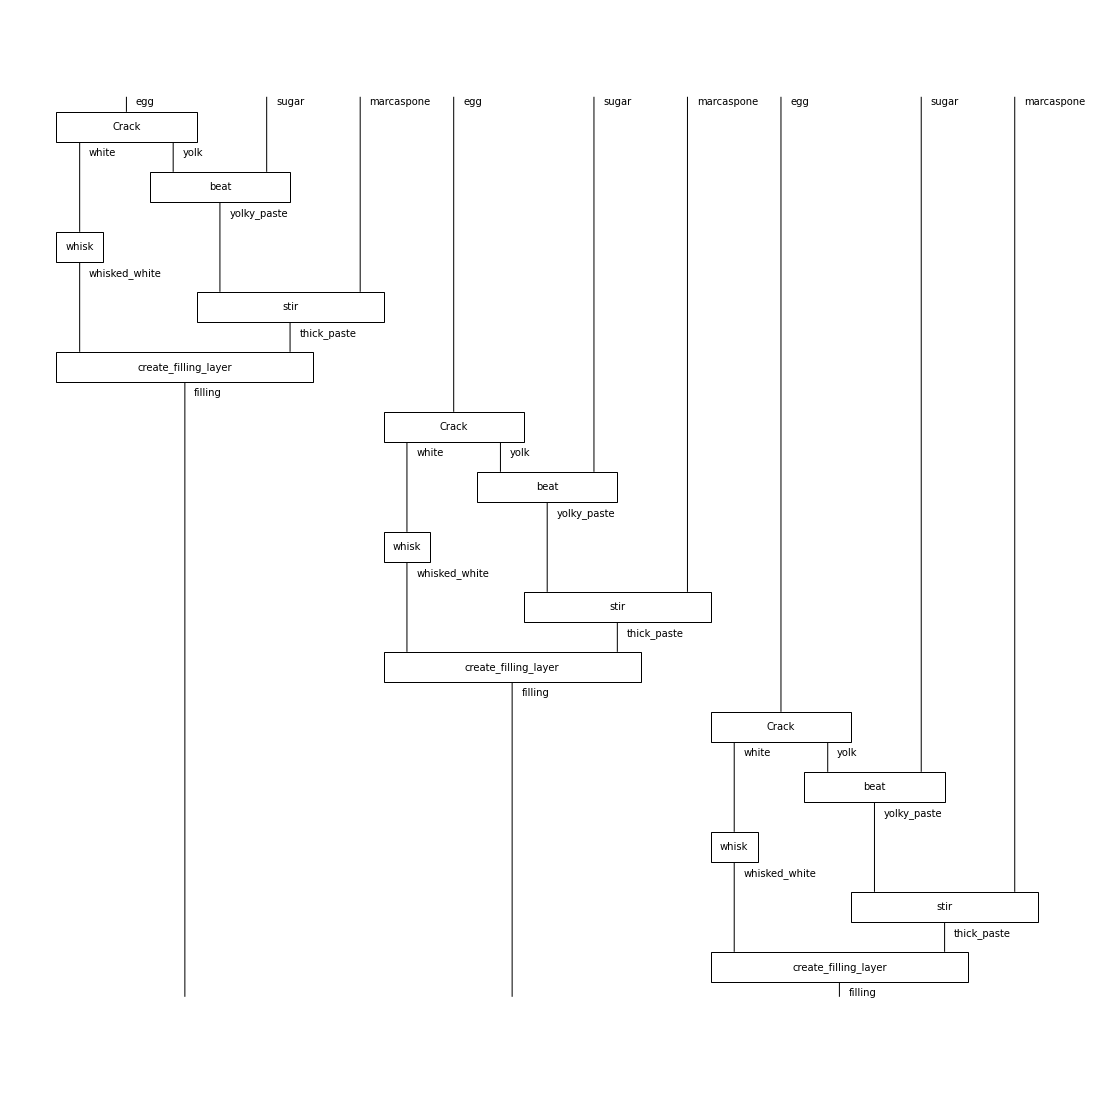

In [6]:
def get_tiramisu_layer(n):
    egg, white, yolk = Ty('egg'), Ty('white'), Ty('yolk')
    crack = Box('Crack', dom=egg, cod=white @ yolk)
    sugar, yolky_paste = Ty('sugar'), Ty('yolky_paste')
    beat = Box('beat', yolk @ sugar, yolky_paste)
    white, whisked_whites = Ty('white'), Ty('whisked_white')
    cream, thick_paste = Ty('marcaspone'), Ty('thick_paste')
    creama = Ty('filling')

    whisk = Box('whisk', white, whisked_whites)

    stir = Box('stir', yolky_paste @ cream, thick_paste)

    create_filling = Box('create_filling_layer', whisked_whites @ thick_paste, creama)

    step_1 = crack @ Id(sugar) @ Id(cream)
    step_2 = Id(white) @ beat  @ Id(cream)
    step_3 = step_1 >> step_2 
    step_4 =  step_3  >>  whisk @ Id(yolky_paste) @ Id(cream)
    step_5 = step_4 >> Id(whisked_whites) @ stir 
    step_6 = step_5 >> create_filling
    answer = step_6

    while(n-1):
        answer @= step_6
        n -= 1
    return answer

get_tiramisu_layer(3).draw(figsize=(15, 15))

### 3. **Exercise (harder):** Define a function that takes a number `n` and returns the recipe for cracking `n` eggs.

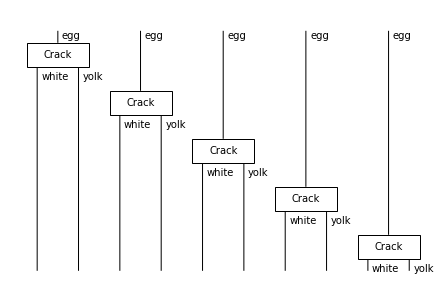

In [24]:
def crack_n_eggs(n):
    egg, cracked_egg = Ty('egg'), Ty('white', 'yolk')
    answer = crack = Box('Crack', dom = egg, cod=cracked_egg)
    while(n-1):
        answer @= crack
        n -= 1
    return answer

crack_n_eggs(5).draw()

### 4. **Exercise :** Define a functor that translate your favorite language to English, try composing it with `english2french`.

In [8]:
egg, white, yolk, sugar, yolky_paste = Ty('egg'), Ty('white'), Ty('yolk'),Ty('sugar'), Ty('yolky_paste')
beat = Box('beat', yolk @ sugar, yolky_paste)
merge = lambda x: Box('merge', x @ x, x)

crack_two_eggs = crack @ crack\
    >> Id(white) @ Swap(yolk, white) @ Id(yolk)\
    >> merge(white) @ merge(yolk)

crack2 = Box("Crack", egg @ egg, white @ yolk)
open_crack2 = Functor(
    ob=lambda x: x,
    ar={crack2: crack_two_eggs, beat: beat})
crack2_then_beat = crack2 @ Id(sugar) >> Id(white) @ beat

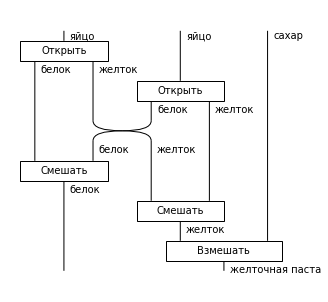

In [9]:
yaitso, belok, zheltok, sahar, zheltochnaya_pasta = Ty("яйцо"), Ty("белок"), Ty("желток"), Ty("сахар"), Ty("желточная паста")

otkryt   = Box("Открыть", yaitso, belok @ zheltok)
vzmeshat = Box("Взмешать", zheltok @ sahar, zheltochnaya_pasta)

smeshat = lambda x: Box("Смешать", x @ x, x)

english2russian = Functor(
    ob={egg: yaitso,
        white: belok,
        yolk: zheltok,
        sugar: sahar,
        yolky_paste: zheltochnaya_pasta},
    ar={crack: otkryt,
        beat: vzmeshat})

for x in [white, yolk]:
    english2russian.ar[merge(x)] = smeshat(english2russian(x))

english2russian(open_crack2(crack2_then_beat)).draw(figsize=(4, 4))

In [10]:
english2russian

Functor(ob={Ty('egg'): Ty('яйцо'), Ty('white'): Ty('белок'), Ty('yolk'): Ty('желток'), Ty('sugar'): Ty('сахар'), Ty('yolky_paste'): Ty('желточная паста')}, ar={Box('Crack', Ty('egg'), Ty('white', 'yolk')): Box('Открыть', Ty('яйцо'), Ty('белок', 'желток')), Box('beat', Ty('yolk', 'sugar'), Ty('yolky_paste')): Box('Взмешать', Ty('желток', 'сахар'), Ty('желточная паста')), Box('merge', Ty('white', 'white'), Ty('white')): Box('Смешать', Ty('белок', 'белок'), Ty('белок')), Box('merge', Ty('yolk', 'yolk'), Ty('yolk')): Box('Смешать', Ty('желток', 'желток'), Ty('желток'))})

### 5. **Exercise:** Define a `french2english` functor, check that it's the inverse of `english2french` on a small example.

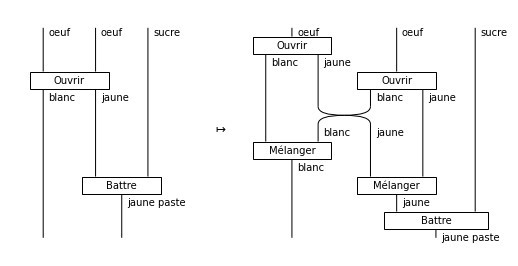

In [11]:
oeuf, blanc, jaune, sucre, jaune_paste = Ty("oeuf"), Ty("blanc"), Ty("jaune"), Ty("sucre"), Ty("jaune paste")

ouvrir = Box("Ouvrir", oeuf, blanc @ jaune)
mix = Box("Mix", blanc @ jaune, oeuf)
battre = Box('Battre', jaune @ sucre, jaune_paste)
melanger = lambda x: Box("Mélanger", x @ x, x)

ouvrir_en_mix = ouvrir >> mix
ouvrir_en_battre = ouvrir @ Id(sucre) >> Id(blanc) @ battre
ouvrir_dieux_oeufs = ouvrir @ ouvrir\
    >> Id(blanc) @ Swap(jaune, blanc) @ Id(jaune)\
    >> melanger(blanc) @ melanger(jaune)

ouvrir2 = Box("Ouvrir", oeuf @ oeuf, blanc @ jaune)

ouvrir_ouvrir2 = Functor(
    ob=lambda x: x,
    ar={ouvrir2: ouvrir_dieux_oeufs, battre: battre})

ouvrir2_en_battre = ouvrir2 @ Id(sucre) >> Id(blanc) @ battre

drawing.equation(
    ouvrir2_en_battre,
    ouvrir_ouvrir2(ouvrir2_en_battre),
    symbol='$\\mapsto$', figsize=(7, 3.5))

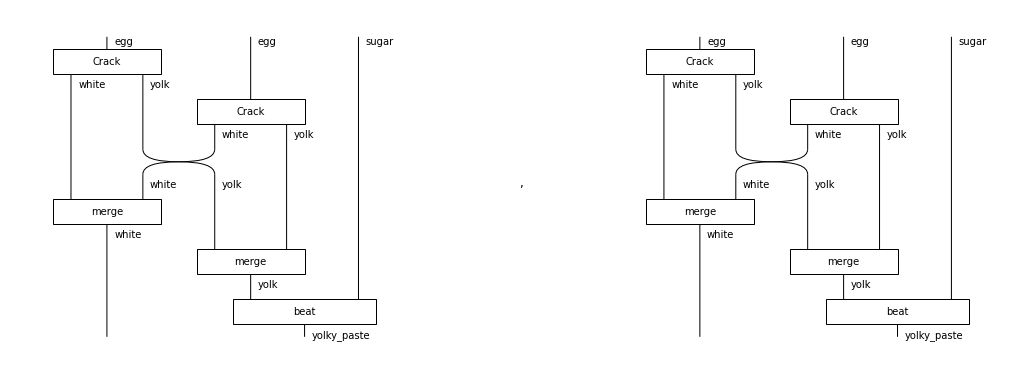

In [12]:
egg, white, yolk, sugar, yolk_paste = Ty("egg"), Ty("white"), Ty("yolk"), Ty("sugar"), Ty("yolky_paste")

crack = Box("Crack", egg, white @ yolk)
mix   = Box('Mix', white @ yolk, egg)
beat  = Box("beat", yolk @ sugar, yolk_paste)
merge = lambda x: Box("merge", x @ x, x)

french2english = Functor(
    ob={oeuf: egg,
        blanc: white,
        jaune: yolk,
        sucre: sugar,
        jaune_paste: yolky_paste},
    ar={ouvrir: crack,
        battre: beat,
        ouvrir2: crack2,
        ouvrir2_en_battre: crack2_then_beat
        })

for x in [blanc, jaune]:
    french2english.ar[melanger(x)] = merge(french2english(x))

assert open_crack2(crack2_then_beat) == french2english(ouvrir_ouvrir2(ouvrir2_en_battre))

drawing.equation(open_crack2(crack2_then_beat), french2english(ouvrir_ouvrir2(ouvrir2_en_battre)), space=2, symbol=', ', figsize=(14, 5))

![exercise2](images/exercise2.png)

### 6. **Exercise:** Check out the [diagram rewriting](https://discopy.readthedocs.io/en/main/notebooks/rewriting-diagrams.html) notebook to learn how to remove snakes from a diagram. This can greatly speed up the evaluation of tensor diagrams!

In [13]:
folder = lambda file: './' + file
params = dict(
    aspect='auto',
    loop=True,
    draw_type_labels=False)

In [14]:
x = Ty('x')
copy, add = Box('copy', x, x @ x), Box('add', x @ x, x)
CX = copy @ Id(x) >> Id(x) @ add
XC = Id(x) @ copy >> add @ Id(x)
diagram = CX @ XC >> XC @ CX
rewrite_steps = diagram.normalize()

diagram.to_gif(*rewrite_steps,
               path=folder('simple-rewrite.gif'), **params)

In [15]:
def spiral(n_cups):
    x = Ty('x')
    unit, counit = Box('unit', Ty(), x), Box('counit', x, Ty())
    cup, cap = Box('cup', x @ x, Ty()), Box('cap', Ty(), x @ x)
    result = unit
    for i in range(n_cups):
        result = result >> Id(x ** i) @ cap @ Id(x ** (i + 1))
    result = result >> Id(x ** n_cups) @ counit @ Id(x ** n_cups)
    for i in range(n_cups):
        result = result >>\
            Id(x ** (n_cups - i - 1)) @ cup @ Id(x ** (n_cups - i - 1))
    return result


diagram = spiral(3)
diagram.to_gif(*diagram.normalize(),
               path=folder('spiral.gif'),
               **dict(params, draw_box_labels=False, loop=True, aspect='equal'))

In [16]:
snake = Box('f', x @ x, x @ x)\
    .transpose(left=True).transpose(left=True)\
    .transpose().transpose()

snake.to_gif(*snake.normalize(), **params,
             path=folder('snake-removal.gif'))

### 7. **Exercise:** Define a function that takes a number `n` and returns the diagram for a [matrix product state](https://en.wikipedia.org/wiki/Matrix_product_state) (MPS) with `n` particles and random entries. Check how the evaluation time scales with the size of the diagram. 

In [17]:
def block(*dimensions):
    size = tuple([x for x in dimensions])
    return np.random.random_sample(size)
    
def MPS_diagram(n,chi):
    A_list=[]
    if n==1:
        return tensor.Box('A'+str(1), Dim(1), Dim(chi), block(chi * chi))
    elif type(n)!=int or n<1:
        raise ValueError ("n should be an integer bigger than zero.")
    else:
        for i in range(n):
            if i==0 or i==n-1:
                temp=tensor.Box('A'+str(i+1), Dim(1), Dim(chi) @ Dim(chi), block(chi * chi))
            else:
                temp=tensor.Box('A'+str(i+1), Dim(1), Dim(chi) @ Dim(chi) @ Dim(chi), block(chi * chi * chi))
            A_list.append(temp)
            #temp.draw()
        layer1=A_list[0]

        for i in range(1,n):
            layer1= layer1@A_list[i]
        #layer1.draw()
        layer2=Id(Dim(chi))

        for _ in range(n-1):
            layer2=layer2 @ (tensor.Diagram.cups(Dim(chi),Dim(chi)) @ Id(Dim(chi)))
        #layer2.draw()

        return layer1>>layer2

In [18]:
MPS=MPS_diagram(4,2)
MPS.eval(contractor=tn.contractors.auto)

Tensor(dom=Dim(1), cod=Dim(2, 2, 2, 2), array=[0.57004777, 0.65738112, 0.61392602, 0.59837979, 0.39119452, 0.30057398,
 0.39359191, 0.32412192, 0.52606108, 0.59164156, 0.56378976, 0.54357913,
 0.32526443, 0.25606302, 0.3283892 , 0.27302795])

In [19]:
### Evaluation time using the default contractor tensor.functor scaling with the diagram size
import timeit

time_discopy=[]
for i in range(2,11):
    result=timeit.timeit('MPS_diagram(i,2).eval()',globals=globals(),number=10)
    time_discopy.append(result)
    print(i,": ",result)

2 :  0.14143516100000042
3 :  0.12871932899999905
4 :  0.18762109200000054
5 :  0.26977275400000167
6 :  0.3189466680000024
7 :  0.48547304899999943
8 :  0.9665495970000002
9 :  7.729637268000001
10 :  81.187585577


### 8. **Exercise:** Pip install the [tensornetwork](https://pypi.org/project/tensornetwork/) library and use it to contract the MPS diagrams more efficiently. This is done with the syntax `diagram.eval(contractor=tn.contractor.auto)`, see the [docs](https://discopy.readthedocs.io/en/main/_autosummary/discopy.tensor.Diagram.html#discopy.tensor.Diagram.eval).

In [20]:
### Evaluation time using tensornetwork scaling with the diagram size
time_tn=[]

for i in range(2,11):
    result=timeit.timeit('MPS_diagram(i,2).eval(contractor=tn.contractors.auto)',globals=globals(),number=10)
    time_tn.append(result)
    print(i,": ",result)

2 :  0.11610830299999009
3 :  0.21801401599999792
4 :  0.35318953099999817
5 :  0.1894672539999931
6 :  0.32735961999999574
7 :  0.38987252799999794
8 :  0.4542950700000006
9 :  0.45635081399998967
10 :  0.5853065520000058


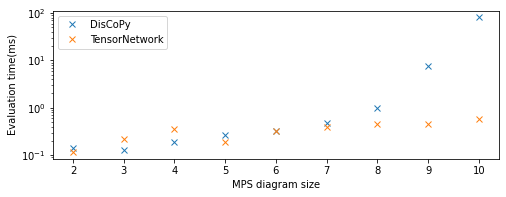

In [21]:
#### Comparison
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(2, 1, 1)

plt.plot(range(2,11),time_discopy,'x',label='DisCoPy')
plt.plot(range(2,11),time_tn,'x',label='TensorNetwork')
ax.set_yscale('log')
plt.ylabel('Evaluation time(ms)')
plt.xlabel('MPS diagram size')
plt.legend()
plt.show()

![exercise3](images/exercise3.png)

### 9. **Exercise:** Run your own Bell experiment on quantum hardware! You can use IBMQ machines for free, if you're ready to wait.

In [22]:
from discopy.quantum import * #qubit, H, Id, CX, QuantumGate, Ket, Bra, Measure, Discard, Swap, sqrt, X, circuit

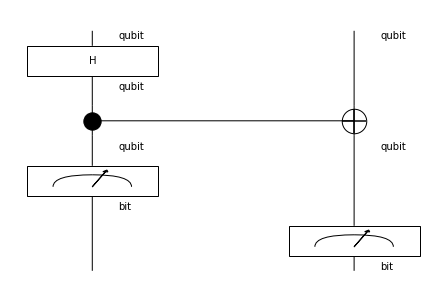

In [23]:
circuit = H @ Id(1) >> CX >> Measure() @ Measure()
circuit.draw()

In [24]:
tk_circ = circuit.to_tk()
list(tk_circ)

[H q[0];, CX q[0], q[1];, Measure q[0] --> c[0];, Measure q[1] --> c[1];]

For the details of the usage of pytket-qiskit, please refer to:
https://cqcl.github.io/pytket/build/html/manual/manual_backend.html

In [25]:
from pytket.extensions.qiskit import IBMQBackend, AerBackend

In [26]:
from qiskit import IBMQ
from qiskit.visualization import plot_histogram
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q-research', group='uni-maryland-1', project='main')>

Here, we choose to use a 5-qubit quantum processor "ibmq_5_yorktown" as the backend to test our circuits.

In [31]:
backend = IBMQBackend("ibmq_bogota")

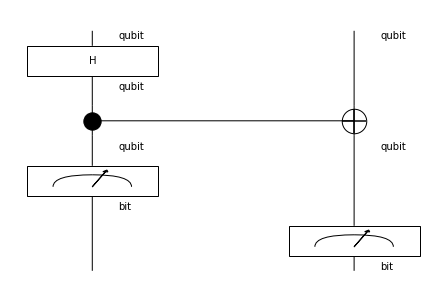

In [32]:
circuit.draw()

In [33]:
counts_qiskit=circuit.get_counts(
    backend=backend,
    n_shots=2**13,
    compilation=backend.default_compilation_pass(2)
)
counts_qiskit

Job Status: job has successfully run


{(0, 0): 0.4879150390625,
 (0, 1): 0.044677734375,
 (1, 0): 0.0234375,
 (1, 1): 0.4439697265625}

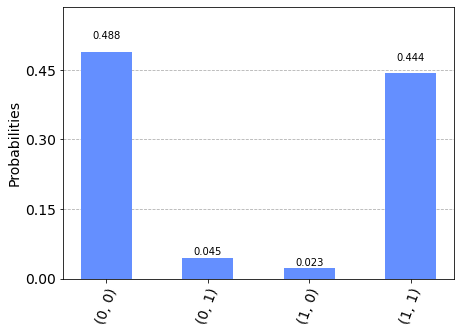

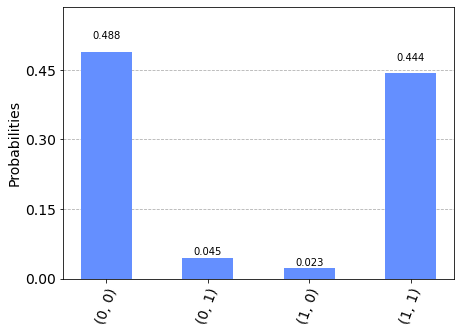

In [34]:
plot_histogram(counts_qiskit)

### 10. **Exercise:** Draw a circuit that evaluates to the GHZ state $\frac{1}{\sqrt{2}} (|000\rangle + |111\rangle)$.

In [37]:
## First, construct the tk circuit and convert it into discopy diagram.
tk_GHZ = tk.Circuit(3).H(0).CX(0, 1).CX(1, 2)
pprint = lambda c: print(str(c).replace(' >>', '\n  >>'))
pprint(Circuit.from_tk(tk_GHZ))

Ket(0)
  >> Id(1) @ Ket(0)
  >> Id(2) @ Ket(0)
  >> H @ Id(2)
  >> CX @ Id(1)
  >> Id(1) @ CX
  >> Discard(qubit) @ Id(2)
  >> Discard(qubit) @ Id(1)
  >> Discard(qubit)


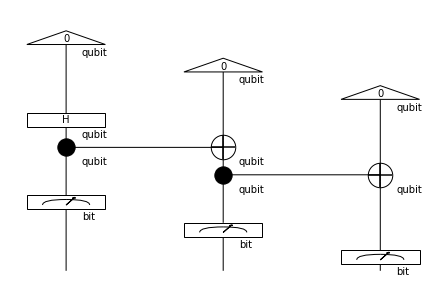

In [38]:
## Ignore the last three "Discard" lines, then add  the measurement for all qubits.
circuit_GHZ = Circuit.from_tk(tk_GHZ)[:-3]>>Measure() @ Measure()@Measure()
circuit_GHZ.draw()

In [39]:
circuit_GHZ_tk=circuit_GHZ.to_tk()
list(circuit_GHZ_tk)

[H q[0];,
 CX q[0], q[1];,
 Measure q[0] --> c[0];,
 CX q[1], q[2];,
 Measure q[1] --> c[1];,
 Measure q[2] --> c[2];]

In [40]:
## Run it on qiskit backend
counts_qiskit_GHZ=circuit_GHZ.get_counts(
    backend=backend,
    n_shots=2**13,
    compilation=backend.default_compilation_pass(2)
)
counts_qiskit_GHZ

Job Status: job has successfully run


{(0, 0, 0): 0.44091796875,
 (0, 0, 1): 0.009521484375,
 (0, 1, 0): 0.00537109375,
 (0, 1, 1): 0.0345458984375,
 (1, 0, 0): 0.0135498046875,
 (1, 0, 1): 0.0277099609375,
 (1, 1, 0): 0.0185546875,
 (1, 1, 1): 0.4498291015625}

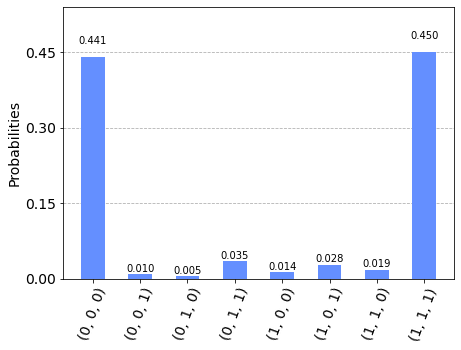

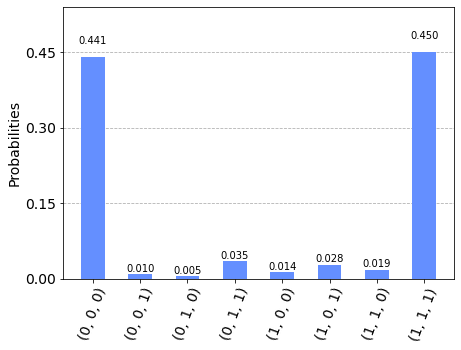

In [41]:
plot_histogram(counts_qiskit_GHZ)

Indeed, the measurement results shows that the probabilities of |000> and |111> states are similarly higher, confirmed to be a GHZ state.
### 11. **Exercise (harder):** Define a function that takes a number `n` and returns a circuit for the  state $\frac{1}{\sqrt{2}} (|0...0\rangle + |1...1\rangle)$.

In [42]:
def Generalized_GHZ(n):
    if type(n)!=int or n<3:
        raise ValueError ("n must be an integer larger than three.")
    tk_GHZ = tk.Circuit(n).H(0)
    for i in range(n-1):
        tk_GHZ=tk_GHZ.CX(i, i+1)
    circ=Circuit.from_tk(tk_GHZ)[:-n] # Discard the last n lines of "Discards"
    measure=Measure()
    for _ in range(n-1):
        measure=measure@Measure()
    circ=circ>>measure
    return circ
    

Check for n=5

In [43]:
n=5
circuit_n_GHZ=Generalized_GHZ(n)

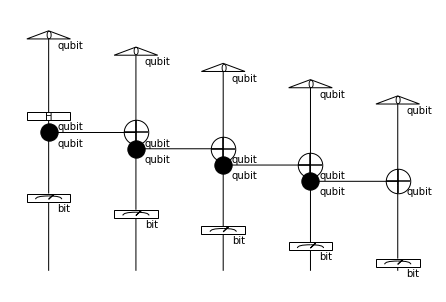

In [44]:
circuit_n_GHZ.draw()

In [45]:
counts_qiskit_n_GHZ=circuit_n_GHZ.get_counts(
    backend=backend,
    n_shots=2**13,
    compilation=backend.default_compilation_pass(2)
)
counts_qiskit_n_GHZ

Job Status: job has successfully run


{(0, 0, 0, 0, 0): 0.41748046875,
 (0, 0, 0, 0, 1): 0.0067138671875,
 (0, 0, 0, 1, 0): 0.0035400390625,
 (0, 0, 0, 1, 1): 0.0052490234375,
 (0, 0, 1, 0, 0): 0.0050048828125,
 (0, 0, 1, 0, 1): 0.00146484375,
 (0, 0, 1, 1, 0): 0.0009765625,
 (0, 0, 1, 1, 1): 0.0289306640625,
 (0, 1, 0, 0, 0): 0.0093994140625,
 (0, 1, 0, 0, 1): 0.0003662109375,
 (0, 1, 0, 1, 1): 0.00048828125,
 (0, 1, 1, 0, 0): 0.00048828125,
 (0, 1, 1, 0, 1): 0.0015869140625,
 (0, 1, 1, 1, 0): 0.000732421875,
 (0, 1, 1, 1, 1): 0.024169921875,
 (1, 0, 0, 0, 0): 0.0062255859375,
 (1, 0, 0, 1, 1): 0.00146484375,
 (1, 0, 1, 0, 0): 0.000244140625,
 (1, 0, 1, 0, 1): 0.000732421875,
 (1, 0, 1, 1, 0): 0.00048828125,
 (1, 0, 1, 1, 1): 0.01953125,
 (1, 1, 0, 0, 0): 0.01123046875,
 (1, 1, 0, 0, 1): 0.0009765625,
 (1, 1, 0, 1, 0): 0.0006103515625,
 (1, 1, 0, 1, 1): 0.02001953125,
 (1, 1, 1, 0, 0): 0.007568359375,
 (1, 1, 1, 0, 1): 0.02197265625,
 (1, 1, 1, 1, 0): 0.015625,
 (1, 1, 1, 1, 1): 0.38671875}

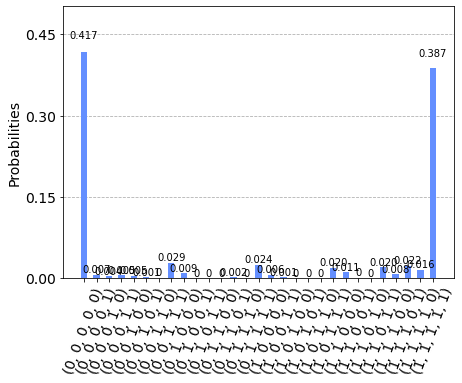

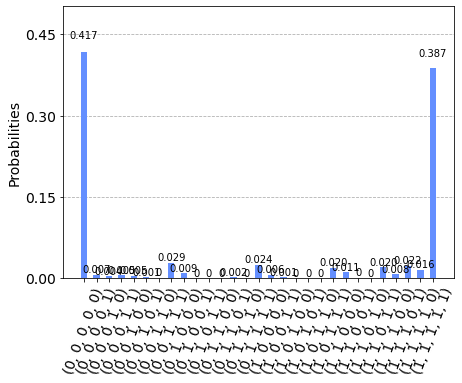

In [46]:
plot_histogram(counts_qiskit_n_GHZ)

Indeed, |00000> and |11111> states are verfied to be the most possible states measured on the IBM backend ibmq_5_yorktown.

![exercise4](images/exercise4.png)

### 12. **Exercise:** Draw the diagram of a sentence in a language with a different word order, e.g. Japanese.

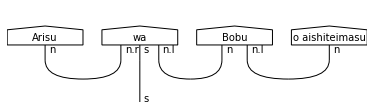

In [47]:
### 1 . Japanese###

n, s = Ty('n'), Ty('s')

wa = Word("wa", n.r @ s @ n.l)
o_aishiteimasu = Word("o aishiteimasu", n)

Arisu = Word("Arisu", n)
Bobu = Word("Bobu", n @ n.l)

grammar2 = Cup(n, n.r) @ Id(s)  @ Cup(n.l, n) @ Cup(n.l, n) 

sentence = Arisu @ wa @ Bobu @ o_aishiteimasu >> grammar2
pregroup.draw(sentence, figsize=(5, 5))

### 13. **Exercise:** Draw the diagram of a sentence in a language written right to left, e.g. Arabic

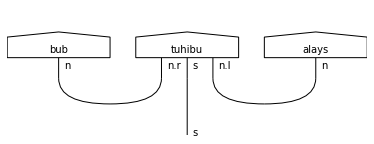

In [48]:
### 2. Arabic

Alice2 = Word("bub", n)
loves2 = Word("tuhibu", n.r @ s @ n.l)
Bob2 = Word("alays", n)

grammar3 = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentence = Alice2 @ loves2 @ Bob2 >> grammar3
pregroup.draw(sentence, figsize=(5, 5))

### 14. ** Reading:** Check out Lambek's [From word to sentence](https://www.math.mcgill.ca/barr/lambek/pdffiles/2008lambek.pdf), pick your favorite example and implement it in DisCoPy.

We choose the sentence "Cannibals prefer man to pork." in this .pdf file.

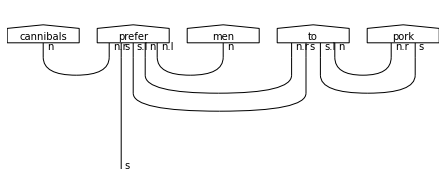

In [49]:
### 3. cannibals prefer man to pork
from discopy import Diagram, grammar
cannibals_prefer = Diagram(
    dom=Ty(),
    cod=Ty('s'),
    boxes=[
        Word('cannibals', Ty('n')),
        Word('prefer', Ty(Ob('n', z=1), 's', Ob('s', z=-1), 'n', Ob('n', z=-1))),
        Word('men', Ty('n')),
        Word('to', Ty(Ob('n', z=1), 's', Ob('s', z=-1), 'n')),
        Word('pork', Ty(Ob('n', z=1), 's')),
        Cup(Ty('n'), Ty(Ob('n', z=1))),
        Cup(Ty(Ob('n', z=-1)), Ty('n')),
        Cup(Ty('n'), Ty(Ob('n', z=1))),
        Cup(Ty(Ob('s', z=-1)), Ty('s')),
        Cup(Ty('n'), Ty(Ob('n', z=1))),
        Cup(Ty(Ob('s', z=-1)), Ty('s'))],
    offsets=[0, 1, 6, 7, 11, 0, 3, 2, 1, 2, 1]
)

#cannibals_prefer.draw()
grammar.draw(cannibals_prefer)

### 15. **Exercise:** Draw your favorite sentence, define the meaning of each word then evaluate it as a tensor.

Who is serious? Batman

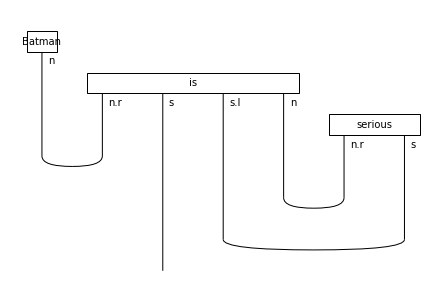

In [50]:
batman = Word("Batman", n)
is_ = Word("is", n.r @ s @ s.l @ n)
serious = Word("serious", n.r @ s)
Who_ = Word("Who", s @ s.l @ n)

layer = Id(s) @ Id(s.l) @ Cup(n, n.r) @ Id(s) 

layer2 = Id(s) @ Cup(s.l, s)

layer_f = Cup(n, n.r) @ layer >> layer2

sentence = batman @ is_ @ serious >> layer_f

sentence.draw()

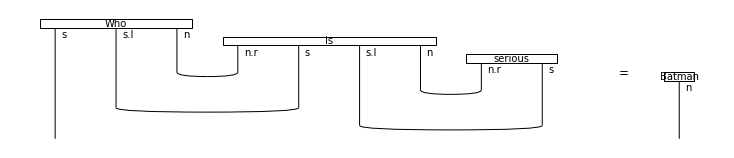

In [51]:
F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={Who_: [1, 0], batman: [1, 0], is_: [[1, 0], [0, 1]], serious: [1, 0]})

assert F(batman @ is_ @ serious >> layer_f) == 1

question = Who_ @ is_ @ serious\
    >> Id(s) @ Id(s.l) @ Cup(n, n.r) @ Id(s) @ Id(s.l) @ Cup(n, n.r) @ Id(s) \
    >> Id(s) @ Cup(s.l, s) @ Cup(s.l, s)


answer = batman

drawing.equation(question, answer, figsize=(10, 2))


### 16. **Exercise:** Build a toy model with a 4-dimensional noun space, add `Charlie` and `Diane` to the story.

Here, we build a toy model with a 4-dimensional noun space with the names of our team members, Eli, Yuval, Henry, and Ming.

In [52]:
## Load this package again to avoid using discopy.quantum.drawing
from discopy import drawing 

q = Ty('q')

n, s = Ty('n'), Ty('s')

Eli = Word("Eli", n)
Yuval = Word("Yuval", n)
Henry = Word("Henry", n)
Ming = Word("Ming", n)
loves = Word("loves", n.r @ s @ n.l)
hates = Word("hates", n.r @ s @ n.l)
Who_ = Word("Who", q @ s.l @ n)
Who__ = Word("Who", q @ s.l @ n)

loves_ = np.zeros((4,4))
loves_[0,3]=1
loves_[1,2]=1
loves_[2,1]=1
loves_[3,0]=1

hates_ = np.zeros((4,4))
hates_[0,0]=1
hates_[1,1]=1
hates_[2,2]=1
hates_[3,3]=1

F = tensor.Functor(
    ob={n: 4, s: 1, q :4},
    ar={Eli: [0, 0, 1, 1],
        Yuval: [1, 1, 0, 0],
        Henry: [1, 1, 0, 0],
        Ming: [0, 0, 1, 1],
        loves: loves_.flatten().tolist(),
        hates: hates_.flatten().tolist(),
        Who_: loves_.flatten().tolist(),
        Who__: hates_.flatten().tolist()
        })

Who loves Eli? Yuval

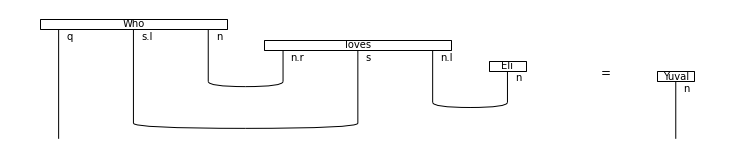

In [53]:
question = Who_ @ loves @ Eli\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

F(question)

answer = Yuval

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(10, 2))

Who loves Eli? Henry

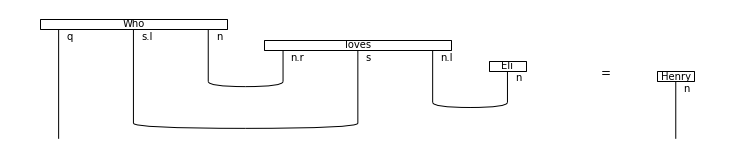

In [54]:
question = Who_ @ loves @ Eli\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

F(question)

answer = Henry

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(10, 2))


Who hates Eli? Ming

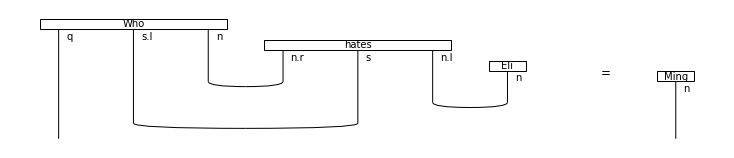

In [55]:
question = Who__ @ hates @ Eli\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

F(question)

answer = Ming

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(10, 2))

Who hates Ming? Eli

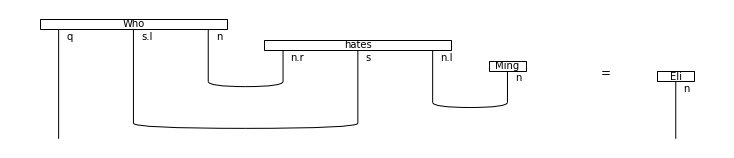

In [56]:
question = Who__ @ hates @ Ming\
    >> Id(q @ s.l) @ Cup(n, n.r) @ Id(s) @ Cup(n.l, n)\
    >> Id(q) @ Cup(s.l, s) 

F(question)

answer = Eli

assert F(question) == F(answer)

drawing.equation(question, answer, figsize=(10, 2))

### **Exercise:** Define the meaning of the word `Does` and draw the diagram for the yes-no question `Does Alice love Bob?`. The meaning of the question should be the same as the sentence `Alice loves Bob`, i.e. the answer is "yes" if the sentence is true.

Does Alice love Bob?

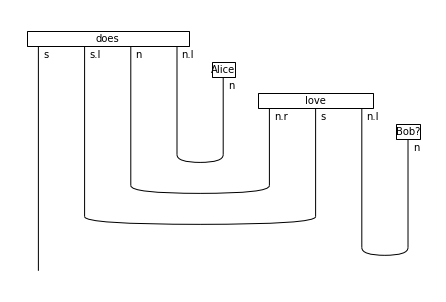

In [57]:
does = Word("does", s @ s.l @ n @ n.l)
Alice = Word("Alice", n)
love = Word("love", n.r @ s @ n.l)
Bob = Word("Bob?", n)

layer3 = Id(s) @ Id(s.l) @ Id(n) @ Cup(n.l, n) @ Id(n.r) @ Id(s) @ Id(n.l) @ Id(n) 

layer4 = Id(s) @ Id(s.l) @ Cup(n, n.r) @ Id(s) @ Id(n.l) @ Id(n) 

layer5 = Id(s) @ Cup(s.l, s) @ Id(n.l) @ Id(n) 

layer6 = Id(s) @ Cup(n.l, n)

layer_f2 = layer3 >> layer4 >> layer5 >> layer6

sentence2 = does @ Alice @ love @ Bob >> layer_f2

sentence2.draw()

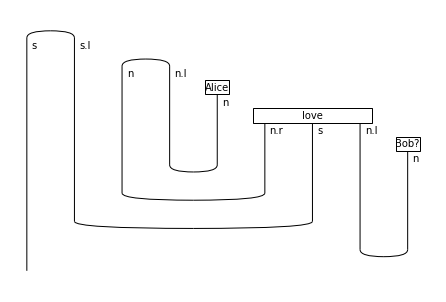

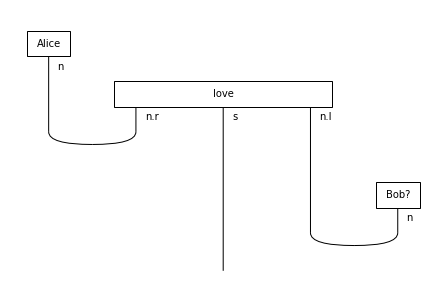

In [58]:
from discopy import rigid, Cap

def cup_map(box):
    if box == does:
        return Cap(s, s.l) @ Cap(n, n.l)
    else:
        return box

R = rigid.Functor(
    ob = lambda x: x,
    ar = cup_map
)

R(sentence2).draw()

R(sentence2).normal_form().draw()

Does Alice love Bob? Yes

Tensor(dom=Dim(1), cod=Dim(1), array=[0.])
yes
True


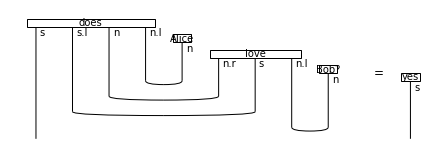

In [59]:
F = tensor.Functor(
    ob={n: 2, s: 1},
    ar={does:[1, 0, 1, 0], Alice: [0, 1], love: [0, 1, 1, 0], Bob: [1, 0]})


yes = Word("yes", s)
F.ar[yes] = [0]

answer = yes

print(F(sentence2))
print(answer)
print(F(sentence2) == F(answer))

assert F(sentence2) == F(answer)

drawing.equation(sentence2, answer, figsize=(6, 2))